## Here we do the model traing, feature selcetion and hyperparmeter tuning

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Handle warnings
import warnings
warnings.filterwarnings("ignore")

### Load the dataset


In [3]:
df_final = pd.read_csv('final_data.csv')
print('Data is upladed successfully!!!')
df_final

Data is upladed successfully!!!


,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,1,1
239,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,0,1
240,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,0,1
241,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,0,1


### Divide fetures into `X` and `y` and split the data into train and test

In [4]:
# selct X and y
X = df_final.drop('FWI', axis=1)
y = df_final['FWI']

In [5]:
# Split into `train` and `test`
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=24)
X_train.shape,X_test.shape

((182, 11), (61, 11))

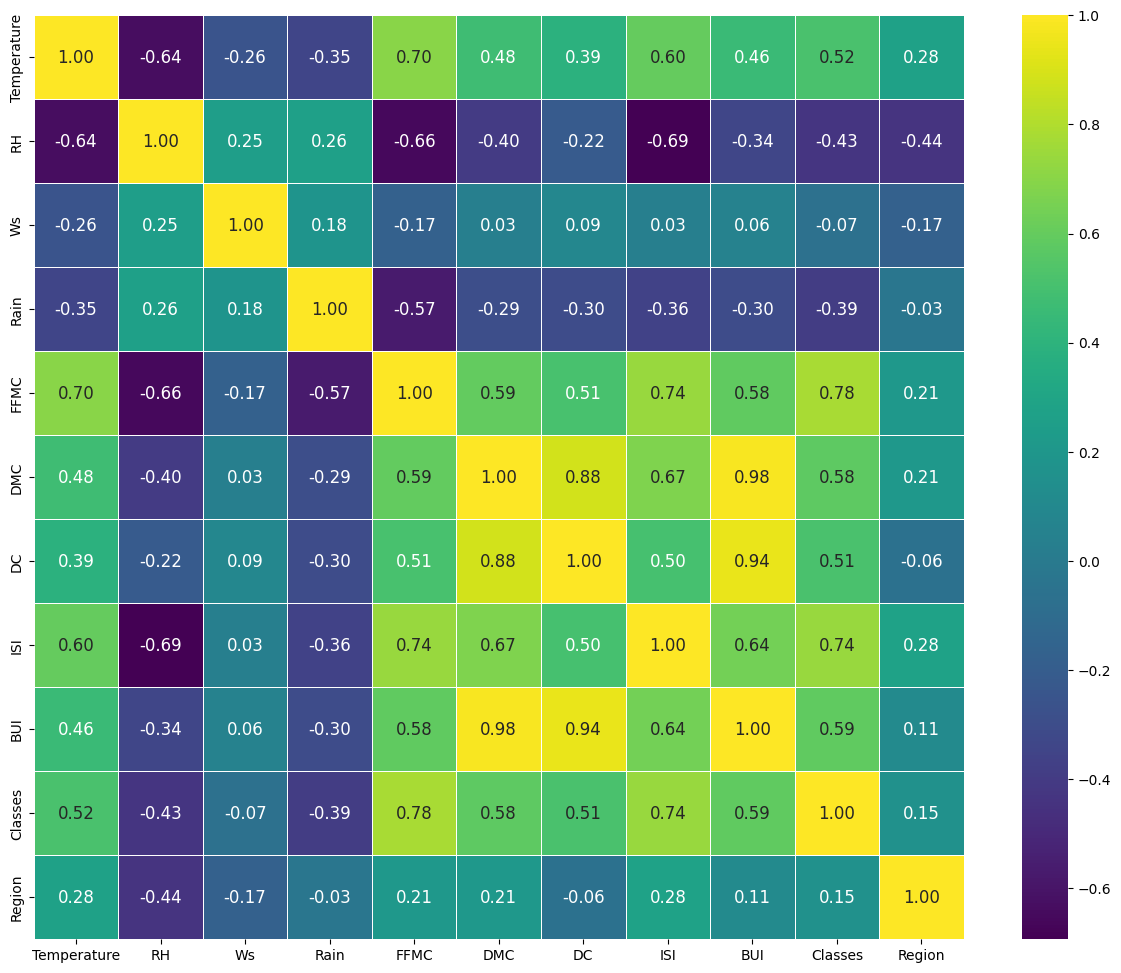

In [6]:
# Feature Selection with correlation
cor_mat = X_train.corr()
cor_mat
plt.figure(figsize=(15,12))
sns.heatmap(cor_mat, annot=True,annot_kws={'size':12}, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.show()

# Function to select features

In [7]:
def correlation(dataset, threshold):
    col_corr = set()    #  to retieve unique values
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [8]:
multi_feature = correlation(X_train, 0.85)
print(f'The features with multicollinearity are {multi_feature}')

The features with multicollinearity are {'DC', 'BUI'}


- We have 'BUE' and 'DC' with high correlation, so need to drop it from the analysis

In [9]:
# Check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_const = add_constant(X_train)
vif_data=pd.DataFrame()
vif_data['Feature'] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)

        Feature         VIF
0         const  427.656058
9           BUI  156.167503
6           DMC   84.099992
7            DC   23.174859
5          FFMC    5.758454
8           ISI    5.419421
10      Classes    3.867580
2            RH    3.518640
1   Temperature    2.324951
11       Region    1.742663
4          Rain    1.649329
3            Ws    1.357993


In [10]:
# Drop features when `correlation` is more than 0.85
X_train.drop(multi_feature, axis=1, inplace=True)
X_test.drop(multi_feature, axis=1, inplace=True)

X_train.shape,X_test.shape

((182, 9), (61, 9))

## Feature Scaling/ Standardization

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n The Scaled TRAIN data : ",X_train_scaled[3])
print("\n The Scaled TEST data : ",X_test_scaled[3])


 The Scaled TRAIN data :  [ 0.01481477 -0.17007924  0.84897638 -0.26449893 -0.00639872 -0.2716357
 -0.5812875  -1.10431526 -0.90553851]

 The Scaled TEST data :  [ 0.28444351 -0.23979641  0.16528744 -0.04225144 -0.20506006 -0.59668478
 -0.72597999 -1.10431526  1.10431526]


### `BOXPlot` to check effect of standardization

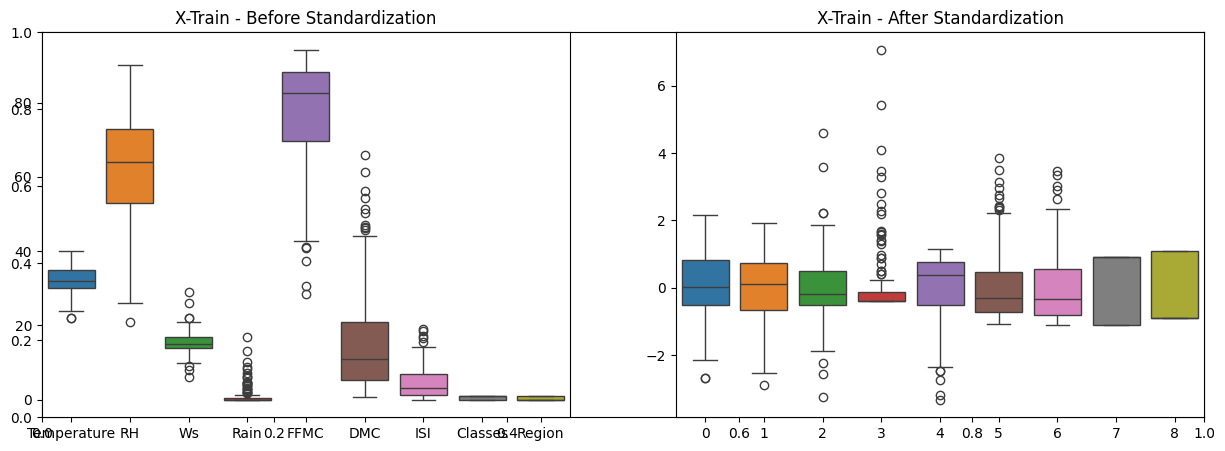

In [12]:
plt.subplots(figsize=(15, 5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('X-Train - Before Standardization')
plt.subplot(1,2,2)
sns.boxplot(data=X_train_scaled)
plt.title('X-Train - After Standardization')
plt.show()

# Model Training

### Linear regression model
We create a linear regression model and fit it on the training data.

Mean Squared error: 0.979
Mean Absolute error: 0.711
Coefficient of determination: 0.980


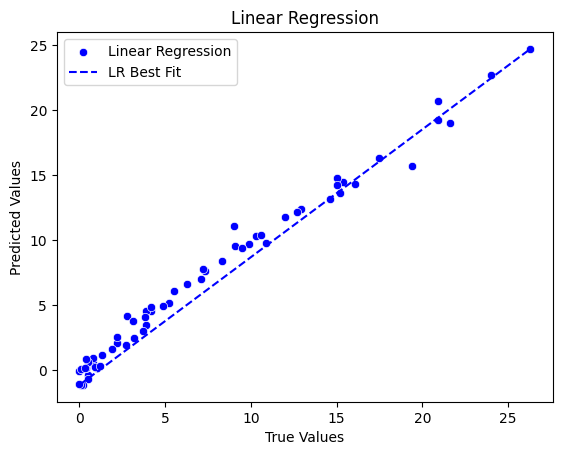

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

lin_reg = LinearRegression()    # object of LinearRegression Class
lin_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lin_reg.predict(X_test_scaled)

# model evaluation
print(f"Mean Squared error: {mean_squared_error(y_test, y_pred_lr):.3f}")
print(f"Mean Absolute error: {mean_absolute_error(y_test, y_pred_lr):.3f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred_lr):.3f}")

# SCatter Plot
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression')
# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_lr), max(y_pred_lr)], color='blue', linestyle='--', label="LR Best Fit")
plt.title('Linear Regression')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## LASSO REGRESSION

Mean Squared error: 2.921
Mean Absolute error: 1.312
Coefficient of determination: 0.941


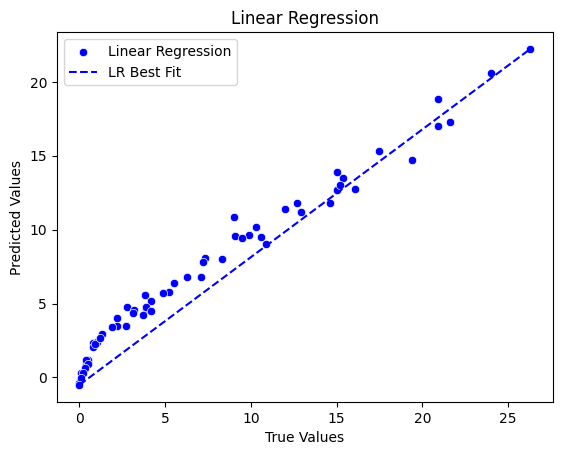

In [14]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

lasso_reg = Lasso()    # object of LASSO Regression Class
lasso_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_lasso = lasso_reg.predict(X_test_scaled)

# model evaluation
print(f"Mean Squared error: {mean_squared_error(y_test, y_pred_lasso):.3f}")
print(f"Mean Absolute error: {mean_absolute_error(y_test, y_pred_lasso):.3f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred_lasso):.3f}")

# SCatter Plot
sns.scatterplot(x=y_test, y=y_pred_lasso, color='blue', label='Linear Regression')
# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_lasso), max(y_pred_lasso)], color='blue', linestyle='--', label="LR Best Fit")
plt.title('Linear Regression')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## RIDGE REGRESSION

Mean Squared error: 1.024
Mean Absolute error: 0.733
Coefficient of determination: 0.979


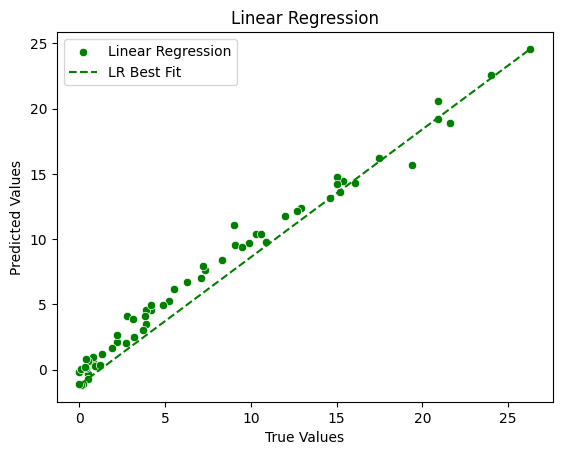

In [15]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

ridge_reg = Ridge()    # object of RIDGE Regression Class
ridge_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_ridge = ridge_reg.predict(X_test_scaled)

# model evaluation
print(f"Mean Squared error: {mean_squared_error(y_test, y_pred_ridge):.3f}")
print(f"Mean Absolute error: {mean_absolute_error(y_test, y_pred_ridge):.3f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred_ridge):.3f}")

# SCatter Plot
sns.scatterplot(x=y_test, y=y_pred_ridge, color='green', label='Linear Regression')
# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_ridge), max(y_pred_ridge)], color='green', linestyle='--', label="LR Best Fit")
plt.title('Linear Regression')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## ELASTICNET REGRESSION

Mean Squared error: 6.141
Mean Absolute error: 1.916
Coefficient of determination: 0.875


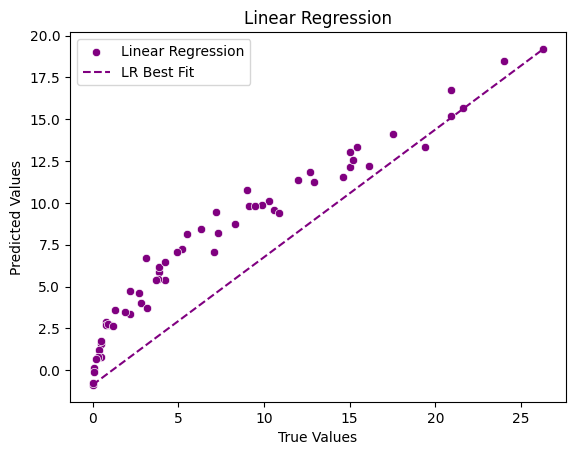

In [16]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

ela_reg = ElasticNet()    # object of ElasticNet Regression Class
ela_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred_ela = ela_reg.predict(X_test_scaled)

# model evaluation
print(f"Mean Squared error: {mean_squared_error(y_test, y_pred_ela):.3f}")
print(f"Mean Absolute error: {mean_absolute_error(y_test, y_pred_ela):.3f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred_ela):.3f}")

# SCatter Plot
sns.scatterplot(x=y_test, y=y_pred_ela, color='purple', label='Linear Regression')
# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_ela), max(y_pred_ela)], color='purple', linestyle='--', label="LR Best Fit")
plt.title('Linear Regression')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

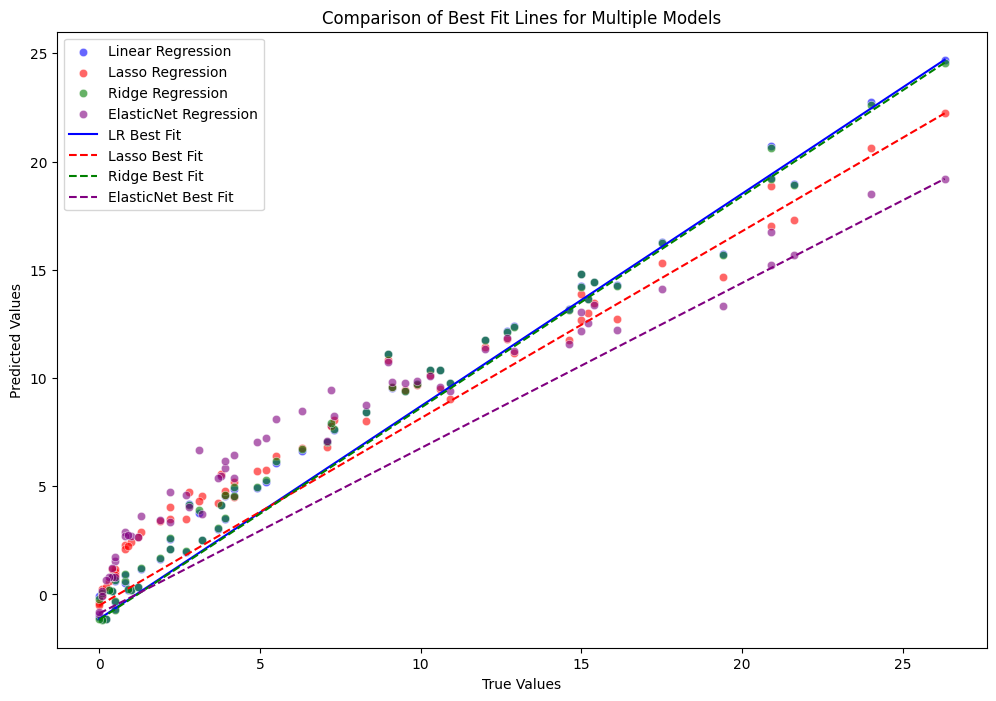

In [17]:
# Step 3: Plotting the best fit lines from each model

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(12, 8))

# Plotting all models
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_lasso, color='red', label='Lasso Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_ridge, color='green', label='Ridge Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_ela, color='purple', label='ElasticNet Regression', alpha=0.6)

# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_lr), max(y_pred_lr)], color='blue', linestyle='-', label="LR Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_lasso), max(y_pred_lasso)], color='red', linestyle='--', label="Lasso Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_ridge), max(y_pred_ridge)], color='green', linestyle='--', label="Ridge Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_ela), max(y_pred_ela)], color='purple', linestyle='--', label="ElasticNet Best Fit")

plt.title('Comparison of Best Fit Lines for Multiple Models')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [18]:
# Print MSE for each model
print(f'R2 Score (Linear Regression): {r2_score(y_test, y_pred_lr):.3f}')
print(f'R2 Score (Lasso Regression): {r2_score(y_test, y_pred_lasso):.3f}')
print(f'R2 Score (Ridge Regression): {r2_score(y_test, y_pred_ridge):.3f}')
print(f'R2 Score (ElasticNet Regression): {r2_score(y_test, y_pred_ela):.3f}')

R2 Score (Linear Regression): 0.980
R2 Score (Lasso Regression): 0.941
R2 Score (Ridge Regression): 0.979
R2 Score (ElasticNet Regression): 0.875


# Hyperparameter Tuning
Hyperparameter tuning is crucial for optimizing model performance. 

# Hyperparameter Tuning for Lasso, Ridge, and ElasticNet Regression

## 1. Lasso Regression (L1 Regularization)

### Important Hyperparameters:

- **`alpha`**:
    - The main regularization parameter in Lasso.
    - It controls the strength of the regularization. Larger values of `alpha` result in more regularization, which reduces the magnitude of coefficients, potentially leading to a sparse model (i.e., many coefficients become zero).
    - **Recommended range**: A logarithmic grid of values is often used, such as `np.logspace(-4, 0, 100)`.
        - This will try values of `alpha` from \(10^{-4}\) to \(10^0\), effectively testing a wide range of regularization strengths.

- **`max_iter`** (Optional):
    - Maximum number of iterations for the optimization process. Increase this if the model is not converging.
    - **Typical default**: 1000 iterations.
    - **Recommended**: Increase it to 5000 or higher if you notice convergence issues.

### Cross-Validation:
- Typically, **5-fold or 10-fold cross-validation** is used.
- **GridSearchCV** or **RandomizedSearchCV** can be used to search through a grid of possible `alpha` values and other hyperparameters to find the best value.

---

## 2. Ridge Regression (L2 Regularization)

### Important Hyperparameters:

- **`alpha`**:
    - Similar to Lasso, `alpha` is the regularization strength parameter.
    - In **Ridge regression**, the larger the value of `alpha`, the stronger the regularization, causing the coefficients to shrink but not exactly to zero.

    - **Recommended range**: Like Lasso, you can use `np.logspace(-4, 0, 100)` for a range of values.

- **`max_iter`**:
    - Similar to Lasso, Ridge also benefits from `max_iter` for ensuring convergence. If you’re using a very high regularization strength (`alpha`), consider increasing the number of iterations.

- **`solver`**:
    - The optimization algorithm to use for solving the regression problem. The common solvers in Ridge regression are:
        - `'auto'`: Automatically selects the best solver based on the data.
        - `'svd'`: Uses singular value decomposition (SVD).
        - `'cholesky'`: Uses a direct method for solving the system of equations.
        - `'lsqr'`: Uses least squares.
        - `'saga'`: Uses stochastic gradient descent (more appropriate for large datasets).

    - **Recommendation**: Generally, `'auto'` works well, but for larger datasets, you might prefer `'saga'`.

### Cross-Validation:
- Similar to Lasso, you should perform **k-fold cross-validation** (typically 5 or 10 folds) to optimize `alpha` and select the best regularization strength.

---

## 3. ElasticNet Regression (Combination of L1 and L2 Regularization)

### Important Hyperparameters:

- **`alpha`**:
    - The regularization strength. Similar to Lasso and Ridge, larger values indicate stronger regularization.
    - **Recommended range**: `np.logspace(-4, 0, 100)`.

- **`l1_ratio`**:
    - This is the key hyperparameter that distinguishes **ElasticNet** from Lasso and Ridge. It controls the mix between Lasso (L1) and Ridge (L2) regularization.
        - `l1_ratio = 1`: Lasso (pure L1).
        - `l1_ratio = 0`: Ridge (pure L2).
        - `l1_ratio = 0.5`: A balanced mix of L1 and L2 regularization.
    
    - **Recommended range**: `np.linspace(0, 1, 11)` to try values from 0 (Ridge) to 1 (Lasso).
    - **Note**: The value of `l1_ratio` affects the sparsity of the model. A higher `l1_ratio` (closer to 1) tends to give sparse solutions, while a lower `l1_ratio` (closer to 0) results in solutions closer to Ridge regression.

- **`max_iter`**:
    - Like the other models, `max_iter` specifies the maximum number of iterations to fit the model. If convergence issues arise, increase this value.

### Cross-Validation:
- As with Lasso and Ridge, cross-validation is essential.
- **5-fold or 10-fold cross-validation** is commonly used for hyperparameter tuning, especially when tuning both `alpha` and `l1_ratio`.


### LassoCV (hyperparameter)

alp =  None
n_iter =  1000
MSE (LassoCV): ,1.021
R2 Score (LassoCV): ,0.979


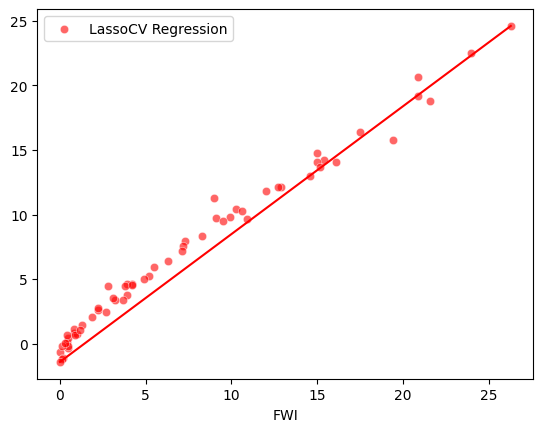

In [19]:
# LassoCV
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV()
lasso_cv.fit(X_train_scaled,y_train)

print('alp = ',lasso_cv.alphas)
print('n_iter = ',lasso_cv.max_iter)

# prediction
y_pred_lassocv = lasso_cv.predict(X_test_scaled) 

# model evaluation
print(f'MSE (LassoCV): ,{mean_squared_error(y_test, y_pred_lassocv):.3f}')
print(f'R2 Score (LassoCV): ,{r2_score(y_test,y_pred_lassocv):.3f}')

# Scatter Plot
sns.scatterplot(x=y_test, y=y_pred_lassocv, color='red', label='LassoCV Regression', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_pred_lassocv), max(y_pred_lassocv)], color='red',label='LassoCV Best Fit')

## RidgeCV

MSE (RidgeCV): 1.024
R2 Score (RidgeCV): 0.979


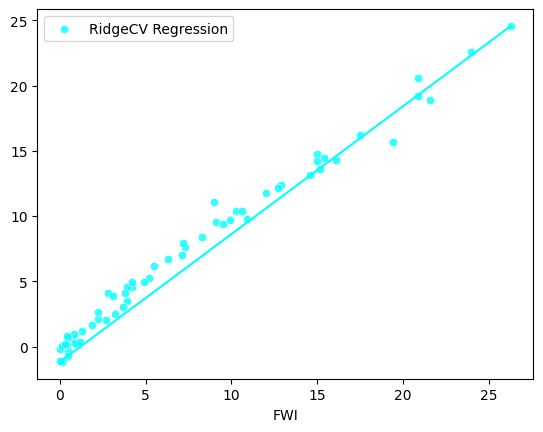

In [20]:
# ridgecv
from sklearn.linear_model import RidgeCV
ridgecv = RidgeCV()
ridgecv.fit(X_train_scaled, y_train)

# predictions
y_pred_ridgecv = ridgecv.predict(X_test_scaled)

# model evaluation
print(f'MSE (RidgeCV): {mean_squared_error(y_test,y_pred_ridgecv):.3f}')
print(f'R2 Score (RidgeCV): {r2_score(y_test,y_pred_ridgecv):.3f}')

# SCatter Plot
sns.scatterplot(x=y_test, y=y_pred_ridgecv, color='cyan',label='RidgeCV Regression', alpha=0.8)
plt.plot([min(y_test),max(y_test)],[min(y_pred_ridgecv),max(y_pred_ridgecv)], color='cyan', label='RidgeCV Best Fit')

## ELasticNet (hyperparameter)

MSE (RidgeCV): 1.200
R2 Score (RidgeCV): 0.976


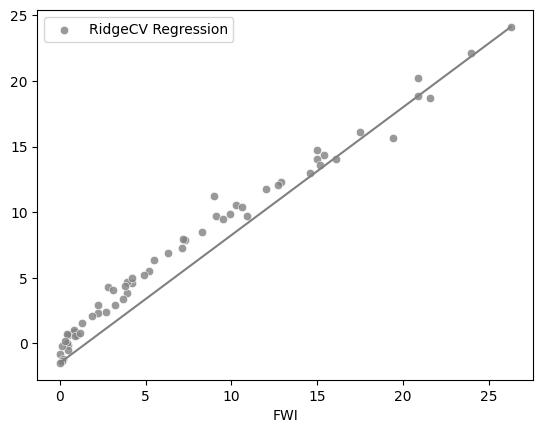

In [21]:
# ridgecv
from sklearn.linear_model import ElasticNetCV
elasticcv = ElasticNetCV()
elasticcv.fit(X_train_scaled, y_train)

# predictions
y_pred_elasticcv = elasticcv.predict(X_test_scaled)

# model evaluation
print(f'MSE (RidgeCV): {mean_squared_error(y_test,y_pred_elasticcv):.3f}')
print(f'R2 Score (RidgeCV): {r2_score(y_test,y_pred_elasticcv):.3f}')

# SCatter Plot
sns.scatterplot(x=y_test, y=y_pred_elasticcv, color='grey',label='RidgeCV Regression', alpha=0.8)
plt.plot([min(y_test),max(y_test)],[min(y_pred_elasticcv),max(y_pred_elasticcv)], color='grey', label='ElasticNetCV Best Fit')

# ALL plot in a single plot after hyperparameter tuning

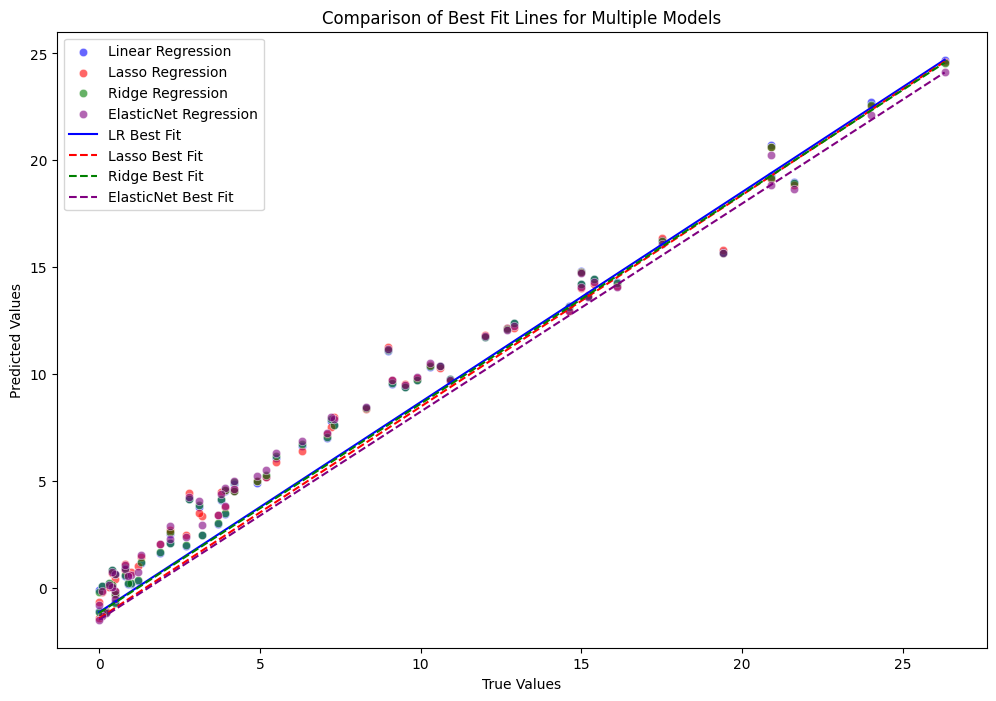

In [22]:
# Step 3: Plotting the best fit lines from each model

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(12, 8))

# Plotting all models
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_lassocv, color='red', label='Lasso Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_ridgecv, color='green', label='Ridge Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_elasticcv, color='purple', label='ElasticNet Regression', alpha=0.6)

# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_lr), max(y_pred_lr)], color='blue', linestyle='-', label="LR Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_lassocv), max(y_pred_lassocv)], color='red', linestyle='--', label="Lasso Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_ridgecv), max(y_pred_ridgecv)], color='green', linestyle='--', label="Ridge Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_elasticcv), max(y_pred_elasticcv)], color='purple', linestyle='--', label="ElasticNet Best Fit")

plt.title('Comparison of Best Fit Lines for Multiple Models')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [23]:
print('='*50)
# Print MSE for each model
print(f'R2 Score before tuning (Linear Regression): {r2_score(y_test, y_pred_lr):.3f}')
print(f'R2 Score before tuning (Lasso Regression): {r2_score(y_test, y_pred_lasso):.3f}')
print(f'R2 Score before tuning (Ridge Regression): {r2_score(y_test, y_pred_ridge):.3f}')
print(f'R2 Score before tuning (ElasticNet Regression): {r2_score(y_test, y_pred_ela):.3f}')
print()
print('='*50)
# Print R2 Squared Score for each model
print(f'R2 Score after tuning (Linear Regression): {r2_score(y_test, y_pred_lr):.3f}')
print(f'R2 Score after tuning (Lasso Regression): {r2_score(y_test, y_pred_lassocv):.3f}')
print(f'R2 Score after tuning (Ridge Regression): {r2_score(y_test, y_pred_ridgecv):.3f}')
print(f'R2 Score after tuning (ElasticNet Regression): {r2_score(y_test, y_pred_elasticcv):.3f}')
print()
print('='*50)

R2 Score before tuning (Linear Regression): 0.980
R2 Score before tuning (Lasso Regression): 0.941
R2 Score before tuning (Ridge Regression): 0.979
R2 Score before tuning (ElasticNet Regression): 0.875

R2 Score after tuning (Linear Regression): 0.980
R2 Score after tuning (Lasso Regression): 0.979
R2 Score after tuning (Ridge Regression): 0.979
R2 Score after tuning (ElasticNet Regression): 0.976



## Subplot before and after tuning models

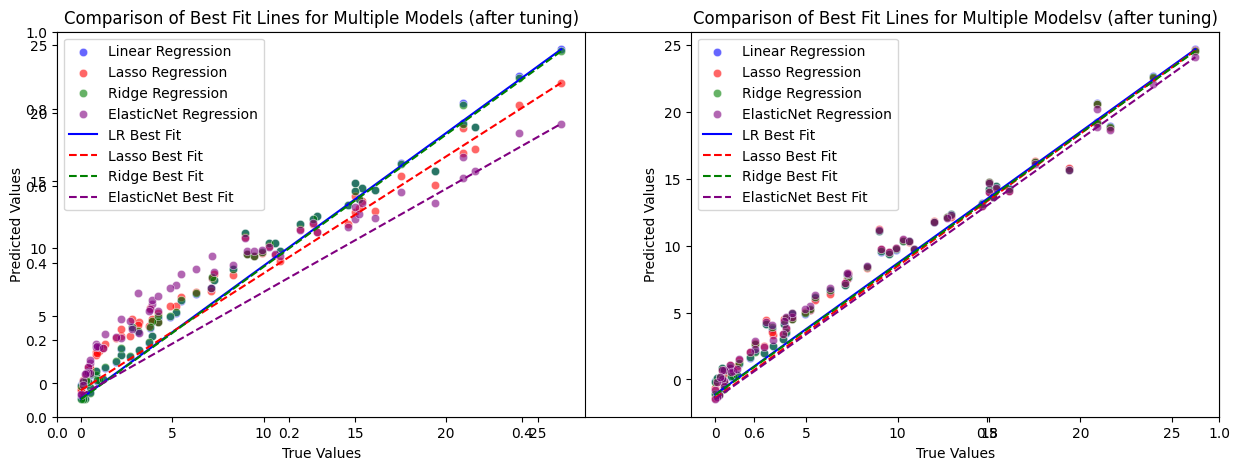

In [24]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
# Plotting all models before tuning
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_lasso, color='red', label='Lasso Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_ridge, color='green', label='Ridge Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_ela, color='purple', label='ElasticNet Regression', alpha=0.6)

# Plot best fit line for each model (using a line of best fit)
plt.plot([min(y_test), max(y_test)], [min(y_pred_lr), max(y_pred_lr)], color='blue', linestyle='-', label="LR Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_lasso), max(y_pred_lasso)], color='red', linestyle='--', label="Lasso Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_ridge), max(y_pred_ridge)], color='green', linestyle='--', label="Ridge Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_ela), max(y_pred_ela)], color='purple', linestyle='--', label="ElasticNet Best Fit")

plt.title('Comparison of Best Fit Lines for Multiple Models (after tuning)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.subplot(1,2,2)
# Plotting all models after tuning
sns.scatterplot(x=y_test, y=y_pred_lr, color='blue', label='Linear Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_lassocv, color='red', label='Lasso Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_ridgecv, color='green', label='Ridge Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=y_pred_elasticcv, color='purple', label='ElasticNet Regression', alpha=0.6)

# Plot best fit line for each model (using a line of best fit) after tuning
plt.plot([min(y_test), max(y_test)], [min(y_pred_lr), max(y_pred_lr)], color='blue', linestyle='-', label="LR Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_lassocv), max(y_pred_lassocv)], color='red', linestyle='--', label="Lasso Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_ridgecv), max(y_pred_ridgecv)], color='green', linestyle='--', label="Ridge Best Fit")
plt.plot([min(y_test), max(y_test)], [min(y_pred_elasticcv), max(y_pred_elasticcv)], color='purple', linestyle='--', label="ElasticNet Best Fit")

plt.title('Comparison of Best Fit Lines for Multiple Modelsv (after tuning)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Pickle 
We will save the models as .pkl files which can be used for prediction

In [27]:
import pickle
# Pickle Standard scaler model
pickle.dump(scaler,open('scaler.pkl','wb'))

# Pickle `Ridge Regression`
pickle.dump(ridge_reg, open('ridge.pkl','wb'))